# Training a model on Fluxnet data

Now all the time-intensive preprocessing steps are over, it is quite easy to preparing the training data and start training the model.

First we combine the ERA5 and Ameriflux data:

In [1]:
from excited_workflow import extract_era5_site_data
from pathlib import Path
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=2)

In [2]:
ds = extract_era5_site_data.combine_era5_fluxnet(
    preprocessed_ameriflux_data=Path("/data/volume_2/NEE_ameriflux_transcom2.nc"),
    preprocessed_era5_folder=Path("/data/volume_2/prep_era5"),
)

The resulting xarray dataset contains all the variables from the preprocessed ameriflux data, as well as the preprocessed ERA5 variables, sorted per site.

This dataset can be modified to add, for example, the sum of incoming solar radiation over the last 6 hours.

In [19]:
# Add 6 hour rolling mean of t2m:
ds["t2m_6hr"] = ds["t2m"].isel(site=0).rolling(time=6).mean()
ds

<xarray.Dataset>
Dimensions:         (time: 271755, site: 61)
Coordinates:
  * time            (time) datetime64[ns] 1991-01-01T06:00:00 ... 2022-01-01T...
  * site            (site) object 'CA-Cbo' 'CA-DB2' ... 'US-Wjs' 'US-xBR'
Data variables: (12/14)
    GPP_NT_VUT_REF  (site, time) float64 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    GPP_DT_VUT_REF  (site, time) float64 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    NEE_VUT_REF     (site, time) float64 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    latitude        (site) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude       (site) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    d2m             (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    ...              ...
    sp              (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    ssr             (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    str             (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    t2m             (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    tp              (site, time) float32 dask.array<chunksize=(1, 271755), meta=np.ndarray>
    t2m_6hr         (time) float32 dask.array<chunksize=(271755,), meta=np.ndarray>

However, for input into `sklearn`, having the data in a pandas dataframe is more practical:

In [20]:
df_train = extract_era5_site_data.generate_training_df(ds)

In [21]:
df_train.head(3)

,site,GPP_NT_VUT_REF,GPP_DT_VUT_REF,NEE_VUT_REF,latitude,longitude,d2m,mslhf,msshf,sp,ssr,str,t2m,tp,t2m_6hr
time,,,,,,,,,,,,,,,
1995-01-01 05:00:00,US-Ha1,-1.413650,0.0,2.54,42.5378,-72.1715,271.487305,-14.701874,32.303574,99037.312500,-0.125,-22880.09375,273.372406,0.000502,272.157745
1995-01-01 06:00:00,US-Ha1,-1.548390,0.0,2.81,42.5378,-72.1715,272.468445,-21.524353,31.094116,98953.078125,-0.125,18727.15625,273.615814,0.000714,272.032867
1995-01-01 07:00:00,US-Ha1,-0.192043,0.0,1.50,42.5378,-72.1715,272.855133,-13.892883,27.152985,98902.414062,-0.125,16623.78125,274.129211,0.000946,271.947296


Note that this dataframe is a "tidy" dataframe, where all dimensions/coordinates have been flattened.
This data is now ready to train a machine learning model.

In [22]:
from sklearn.ensemble import RandomForestRegressor

y_key = "GPP_DT_VUT_REF"
X_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m", "t2m_6hr"]

site_mask = df_train["site"] != "US-Ha1"

df_reduced = df_train[::24]  # Select a reduced size dataset for easier testing.
site_mask_r = df_reduced["site"] != "US-Ha1"
X_train= df_reduced[X_keys][site_mask_r]
y_train = df_reduced[y_key][site_mask_r]
X_test = df_train[X_keys][~site_mask]
y_test = df_train[y_key][~site_mask]

Let's train the random forest regressor:

In [23]:
rfr = RandomForestRegressor()
rfr.fit(X_train[:1000], y_train[:1000])

RandomForestRegressor()

We left one site out for validation. We can compute the score as follows:

In [24]:
rfr.score(X_test, y_test)

0.6732181734837155

Let's see what the model predicts, as diurnal pattern

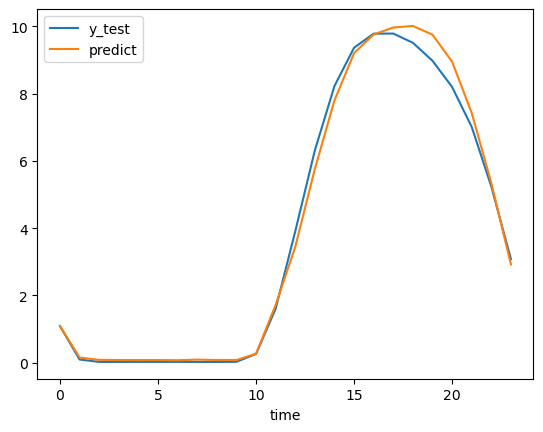

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
df_results = pd.DataFrame(y_test.rename("y_test"))
df_results["predict"] = rfr.predict(X_test)
df_results["y_test"].groupby(df_results.index.hour).mean().plot()
df_results["predict"].groupby(df_results.index.hour).mean().plot()
plt.legend()

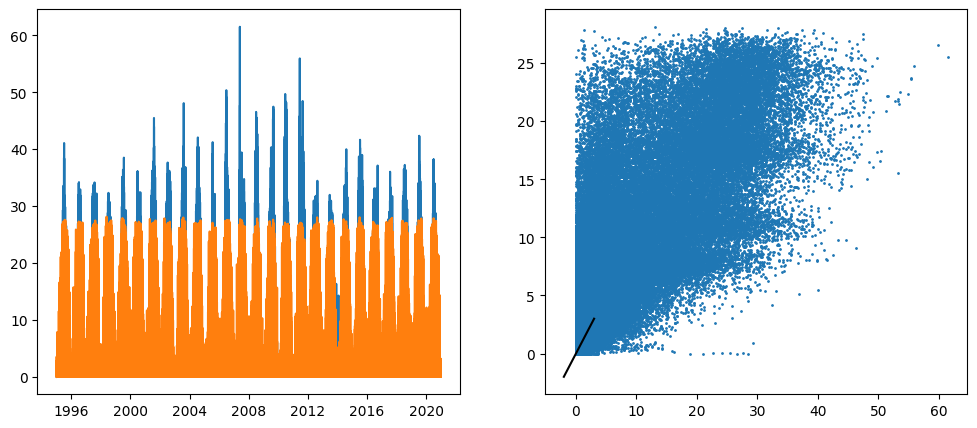

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
ax1.plot(y_test.index, y_test.values)
ax1.plot(y_test.index, rfr.predict(X_test))
ax2.scatter(y_test.values, rfr.predict(X_test), s=1)
ax2.plot([-2, 3], [-2, 3], c="k")